In [185]:
from FrozenYoghourt import *
from FrozenYoghourt.mode import *
from FrozenYoghourt.gates import *
from FrozenYoghourt.maths import *
from FrozenYoghourt.quantum import *
from FrozenYoghourt.circuit import *
from FrozenYoghourt.visualization import *

from scipy.linalg import polar
from scipy.linalg import block_diag

from qiskit import *

In [ ]:
U = random_unitary(8).data

In [277]:
class BlockZXZ:
    
    def __init__(self, U):
        
        self.U = U
        
    def ZXZ_decomposition(self):
        
        dim = int(np.sqrt(self.U.size) / 2)

        # Split matrix into subblocks and polar decomposition
        V11, P11 = polar(self.U[:dim, :dim], side = 'left')
        V12, P12 = polar(self.U[:dim, dim:], side = 'left')
        V21, P21 = polar(self.U[dim:, :dim], side = 'left')
        V22, P22 = polar(self.U[dim:, dim:], side = 'left')

        # Fuhr and Rzeszotnik method
        self.A = (P11 + 1j* P12)@V11
        self.B = (P21 - 1j*P22)@V21
        self.C = dagger(V11)@(P11 - 1j*P12)@(P11 - 1j*P12)@V11
        self.D = -1j*dagger(V11)@V12
        
        assert close(block_diag(self.A, self.B)@np.block([[np.eye(dim)+self.C, np.eye(dim) - self.C], 
        [np.eye(dim)-self.C, np.eye(dim) + self.C]])/2 @ block_diag(np.eye(dim), self.D) , U)
        
        return self.A, self.B, self.C, self.D
    
    def ID_demultiplexing(self):
        Ds, self.V1 = np.linalg.eig(dagger(D))
        self.D1 = np.diag(np.exp(1j/2*np.angle(Ds)))
        
        self.W1 = self.D1@dagger(self.V1)
        
        return self.V1, self.D1, self.W1
    
    def AB_demultiplexing(self):
        Ds, self.V2 = np.linalg.eig(A@dagger(B))
        self.D2 = np.diag(np.exp(1j/2*np.angle(Ds)))
        
        self.W2 = self.D2@dagger(self.V2)@B
        
        return self.V2, self.D2, self.W2

In [282]:
def modified_angles(angles):
    hadamard = np.array([[1, 1], [1, -1]])
    
    dim = int(np.log2(len(angles)))
    coef_mat = tp(*[hadamard]*dim) # Tensor Product of Hadamard
    modified_angles = angles@coef_mat / 2**dim
    
    return modified_angles

def multiplex_crz(circ, angles, control_bit = 0, flip = False):
    
    """
    Build optimized multiplexed crz gate
    
    Parameters
    ----------
    circ : QuantumCircuit
        The circuit to which the multiplexed crz gate is applied.
    
    angles : list
        The list of angles to be applied to the multiplexed crz gate.
    
    control_bit : int
        The control bit for the multiplexed crz gate.
    
    flip : bool
        A boolean to determine whether the multiplexed crz gate is flipped or not.
    
    Returns
    -------
    None
        The multiplexed crz gate is applied to the circuit.
    """
    
    len_angles = len(angles)
    no_qubits = circ.num_qubits
    
    if len_angles == 2 and not flip: ### Base case with Optimzation
        circ.rz(angles[0], no_qubits-1)
        circ.cx(no_qubits-2, no_qubits-1)
        circ.rz(angles[1], no_qubits-1)
        
        if no_qubits == 2:
            circ.cx(no_qubits-2, no_qubits-1)
            
        return None
    
    elif len_angles == 2 and flip: ### Base case with Optimzation
        
        circ.rz(angles[1], no_qubits-1)
        circ.cx(no_qubits-2, no_qubits-1)
        circ.rz(angles[0], no_qubits-1)
        return None
    
    else: ### Recursion
        multiplex_crz(circ, angles[:len_angles//2], control_bit+1, flip = False)
        circ.cx(control_bit, no_qubits - 1)
        multiplex_crz(circ, angles[len_angles//2:], control_bit+1, flip = True)
        circ.cx(control_bit, no_qubits - 1)

In [304]:
def multiplex_cry(circ, angles, control_bit = 0, flip = False): # Build optimized multiplexed cry gate
    
    len_angles = len(angles)
    no_qubits = circ.num_qubits
    
    if len_angles == 2 and not flip: ### Base case with Optimzation
        circ.ry(angles[0], no_qubits-1)
        circ.cz(no_qubits-2, no_qubits-1)
        circ.ry(angles[1], no_qubits-1)
        
        if no_qubits == 2:
            circ.cz(no_qubits-2, no_qubits-1)  
            
        return None
                
    elif len_angles == 2 and flip: ### Base case with Optimzation
        circ.ry(angles[1], no_qubits-1)
        circ.cz(no_qubits-2, no_qubits-1)
        circ.ry(angles[0], no_qubits-1)
        return None
    
    else: ### Recursion
        multiplex_cry(circ, angles[:len_angles//2], control_bit+1, flip = False)
        circ.cz(control_bit, no_qubits - 1)
        multiplex_cry(circ, angles[len_angles//2:], control_bit+1, flip = True)
        circ.cz(control_bit, no_qubits - 1)

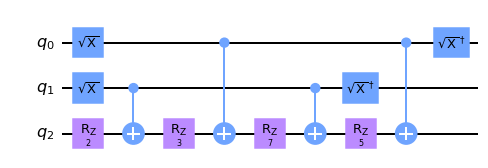

In [310]:
circ = QuantumCircuit(3)
circ.sx([0, 1])
multiplex_crz(circ, [2, 3, 5, 7], flip = True)
circ.sxdg([0, 1])
circ.draw('mpl')

In [312]:
Matrix(Operator(circ).data)

Matrix([
[-0.147537206604386 - 0.157800223078315*I,  0.257304160068597 + 0.118100143904174*I,  -0.41683494707824 + 0.621697088383424*I, -0.285322536207161 + 0.481156102535532*I,                                        0,                                        0,                                        0,                                        0],
[-0.257304160068597 - 0.118100143904174*I, -0.147537206604386 - 0.157800223078315*I,  0.285322536207161 - 0.481156102535532*I,  -0.41683494707824 + 0.621697088383424*I,                                        0,                                        0,                                        0,                                        0],
[  0.41683494707824 - 0.621697088383424*I,  0.285322536207161 - 0.481156102535532*I, -0.147537206604386 - 0.157800223078315*I,  0.257304160068597 + 0.118100143904174*I,                                        0,                                        0,                                        0,                     

Matrix([
[-0.602011902684824,  -0.79848711262349,                  0,                  0,                  0,                  0,                 0,                  0],
[  0.79848711262349, -0.602011902684824,                  0,                  0,                  0,                  0,                 0,                  0],
[                 0,                  0, 0.0707372016677029,  0.997494986604054,                  0,                  0,                 0,                  0],
[                 0,                  0, -0.997494986604054, 0.0707372016677029,                  0,                  0,                 0,                  0],
[                 0,                  0,                  0,                  0, -0.936456687290796,  -0.35078322768962,                 0,                  0],
[                 0,                  0,                  0,                  0,   0.35078322768962, -0.936456687290796,                 0,                  0],
[                 0,     